<a href="https://colab.research.google.com/github/MohammedAfthab18/Path-Planning-with-PSO/blob/main/uav_path_planning_with_pso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from scipy.io import savemat
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
%matplotlib inline

In [2]:
def create_model():

    # Source
    xs = 0
    ys = 0
    zs = 0

    # Target (Destination)
    xt = 4
    yt = 5
    zt = 5

    xobs = [1.5, 4.0, 1.2]
    yobs = [4.5, 3.0, 1.5]
    zobs = [4.5, 3.0, 1.5]
    robs = [0.6, 0.6, 0.8]

    n = 10

    xmin = 0
    xmax = 6

    ymin = 0
    ymax = 6

    zmin = -10
    zmax = 10

    model = {
        "xs": xs,
        "ys": ys,
        "zs": zs,
        "xt": xt,
        "yt": yt,
        "zt": zt,
        "xobs": xobs,
        "yobs": yobs,
        "zobs": zobs,
        "robs": robs,
        "n": n,
        "xmin": xmin,
        "xmax": xmax,
        "ymin": ymin,
        "ymax": ymax,
        "zmin": zmin,
        "zmax": zmax,
    }

    return model

In [3]:
def create_random_solution(model):

    n = model["n"]

    xmin = model["xmin"]
    xmax = model["xmax"]

    ymin = model["ymin"]
    ymax = model["ymax"]

    sol1 = {
        "x": np.random.uniform(xmin, xmax, size=n),
        "y": np.random.uniform(ymin, ymax, size=n),
    }

    return sol1

In [4]:
def my_cost(sol1, model):

    sol = parse_solution(sol1, model)

    beta = 100
    z = sol["L"] * (1 + beta * sol["Violation"])

    return z, sol

In [5]:
import numpy as np
from scipy.interpolate import splprep, splev, splrep, interp1d

def parse_solution(sol1, model):

    x = sol1["x"]
    y = sol1["y"]

    xs = model["xs"]
    ys = model["ys"]
    xt = model["xt"]
    yt = model["yt"]
    xobs = model["xobs"]
    yobs = model["yobs"]
    robs = model["robs"]

    XS = [xs] + x.tolist() + [xt]
    YS = [ys] + y.tolist() + [yt]

#     print(XS)

    k = len(XS)
    TS = np.linspace(0, 1, k)

    tt = np.linspace(0, 1, 100)
    xx = splrep(TS, XS, k=3)
    yy = splrep(TS, YS, k=3)
    x_interpolated = splev(tt, xx)
    y_interpolated = splev(tt, yy)

    dx = np.diff(x_interpolated)
    dy = np.diff(y_interpolated)

    L = np.sqrt(np.sum(np.square(dx) + np.square(dy)))

    nobs = len(xobs)
    Violation = 0
    for k in range(nobs):
        d = np.sqrt((x_interpolated - xobs[k])**2 + (y_interpolated - yobs[k])**2)
        v = np.maximum(1 - d/robs[k], 0)
        Violation += np.mean(v)

#     print(x_interpolated)

    sol2 = {
        "TS": TS,
        "XS": XS,
        "YS": YS,
        "tt": np.linspace(0, 1, 100),
        "xx": x_interpolated,
        "yy": y_interpolated,
        "dx": dx,
        "dy": dy,
        "L": L,
        "Violation": Violation,
        "IsFeasible": (Violation == 0),
    }

    return sol2

In [6]:
def PlotSolution(sol, model):
    xs = model['xs']
    ys = model['ys']
    xt = model['xt']
    yt = model['yt']
    xobs = model['xobs']
    yobs = model['yobs']
    robs = model['robs']

    XS = sol['XS']
    YS = sol['YS']
    xx = sol['xx']
    yy = sol['yy']

    theta = np.linspace(0, 2*np.pi, 100)
    for k in range(len(xobs)):
        plt.fill(xobs[k] + robs[k]*np.cos(theta), yobs[k] + robs[k]*np.sin(theta), [0.5, 0.7, 0.8])

    plt.plot(xx, yy, 'k', linewidth=2)
    plt.plot(XS, YS, 'ro')
    plt.plot(xs, ys, 'bs', markersize=12, markerfacecolor='y')
    plt.plot(xt, yt, 'kp', markersize=16, markerfacecolor='g')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

In [7]:
def PlotSolution2(sol, model):

    fig, ax = plt.subplots()
    xs = model['xs']
    ys = model['ys']
    xt = model['xt']
    yt = model['yt']
    xobs = model['xobs']
    yobs = model['yobs']
    robs = model['robs']

    XS = sol['XS']
    YS = sol['YS']
    xx = sol['xx']
    yy = sol['yy']

    ax.clear()

    theta = np.linspace(0, 2*np.pi, 100)
    for k in range(len(xobs)):
        ax.fill(xobs[k] + robs[k]*np.cos(theta), yobs[k] + robs[k]*np.sin(theta), [0.5, 0.7, 0.8])


    ax.plot(xx, yy, 'k', linewidth=2)
    ax.plot(XS, YS, 'ro')
#     ax.plot(xs, ys, 'bs', markersize=12, markerfacecolor='y')
    ax.plot(xs, ys, marker=(3, 0, np.rad2deg(np.pi/4)), markersize=12, markerfacecolor='y')

    ax.plot(xt, yt, 'kp', markersize=16, markerfacecolor='g')
    ax.grid(True)
    ax.axis('equal')
    plt.show()

In [8]:
model = create_model()

model["n"] = 3  # number of Handle Points

CostFunction = lambda x: my_cost(x, model)    # Cost Function

nVar = model["n"]       # Number of Decision Variables

VarSize = (1, nVar)   # Size of Decision Variables Matrix

VarMin = {"x": model["xmin"], "y": model["ymin"]}           # Lower Bound of Variables
VarMax = {"x": model["xmax"], "y": model["ymax"]}           # Upper Bound of Variables


## PSO Parameters

MaxIt = 220           # Maximum Number of Iterations

nPop = 150           # Population Size (Swarm Size)

w = 1                # Inertia Weight
wdamp = 0.98         # Inertia Weight Damping Ratio
c1 = 1.5             # Personal Learning Coefficient
c2 = 1.5             # Global Learning Coefficient

alpha = 0.1
VelMax = {"x": alpha * (VarMax["x"] - VarMin["x"]), "y": alpha * (VarMax["y"] - VarMin["y"])}   # Maximum Velocity
VelMin = {"x": -VelMax["x"], "y": -VelMax["y"]}                                                 # Minimum Velocity

## Initialization

# Create Empty Particle Structure
empty_particle = {"Position": None,
                  "Velocity": None,
                  "Cost": None,
                  "Sol": None,
                  "Best": {"Position": None,
                           "Cost": None,
                           "Sol": None}}

# Initialize Global Best
GlobalBest = {"Cost": np.inf}

# Create Particles Matrix
particle = np.tile(empty_particle, (nPop, 1))

In [9]:
# create an empty particle list
particle = []

# Initialization Loop
for i in range(nPop):

    # Initialize Particle
    xx = np.array([0.1, 3,5.0])
    yy = np.array([0.1, 3,5.0])

    new_particle = {
        'Position': {'x': xx, 'y': yy},
        'Velocity': {'x': None, 'y': None},
        'Cost': None,
        'Sol': None,
        'Best': {
            'Position': {'x': None, 'y': None},
            'Cost': None,
            'Sol': None
        }
    }

    # Initialize Position
    if i > 0:
        solu_1 = create_random_solution(model)
        new_particle['Position'] = {'x': solu_1['x'], 'y': solu_1['y']}

    # Initialize Velocity
    new_particle['Velocity']['x'] = np.zeros(VarSize)
    new_particle['Velocity']['y'] = np.zeros(VarSize)

    # Evaluation
    new_particle['Cost'], new_particle['Sol'] = CostFunction(new_particle['Position'])

    # Update Personal Best
    new_particle['Best']['Position'] = new_particle['Position']
    new_particle['Best']['Cost'] = new_particle['Cost']
    new_particle['Best']['Sol'] = new_particle['Sol']

    # Add particle to the list
    particle.append(new_particle)

    # Update Global Best
    if new_particle['Best']['Cost'] < GlobalBest['Cost']:
        GlobalBest = new_particle['Best']

<a id="pso_main"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#003d99;overflow:hidden"><b>PSO Main Loop</b></div>

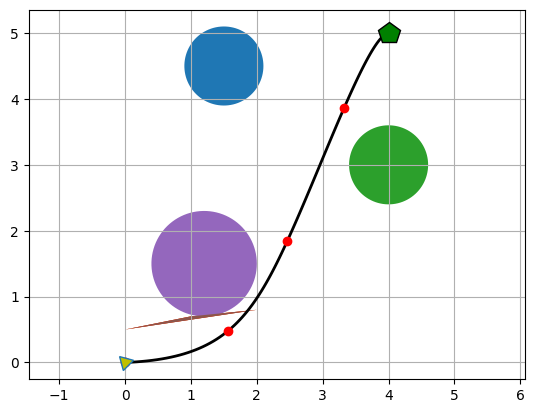

In [10]:
BestCost = np.zeros(MaxIt)
frames = []

for it in range(MaxIt):
    for i in range(nPop):
        # Update x part
        # Update velocity
        particle[i]['Velocity']['x'] = w*particle[i]['Velocity']['x'] \
            + c1*np.random.rand(*VarSize)*(particle[i]['Best']['Position']['x']-particle[i]['Position']['x']) \
            + c2*np.random.rand(*VarSize)*(GlobalBest['Position']['x']-particle[i]['Position']['x'])
        # Update velocity bounds
        particle[i] ['Velocity'] ['x'] = np.maximum(particle[i] ['Velocity'] ['x'], VelMin ['x'])
        particle[i] ['Velocity'] ['x'] = np.minimum(particle[i] ['Velocity'] ['x'], VelMax ['x'])
        # Update position
        particle[i] ['Position'] ['x'] = particle[i] ['Position'] ['x'] + particle[i] ['Velocity'] ['x']
        # Velocity mirroring
        OutOfTheRange = (particle[i] ['Position'] ['x']<VarMin ['x']) | (particle[i] ['Position'] ['x']>VarMax ['x'])
        particle[i] ['Velocity'] ['x'][OutOfTheRange] = -particle[i] ['Velocity'] ['x'][OutOfTheRange]
        # Update position bounds
        particle[i] ['Position'] ['x'] = np.maximum(particle[i] ['Position'] ['x'], VarMin ['x']).flatten()
        particle[i] ['Position'] ['x'] = np.minimum(particle[i] ['Position'] ['x'], VarMax ['x']).flatten()

        # Update y part
        # Update velocity
        particle[i] ['Velocity']['y'] = w*particle[i] ['Velocity']['y'] \
            + c1*np.random.rand(*VarSize)*(particle[i]['Best']['Position']['y']-particle[i] ['Position']['y']) \
            + c2*np.random.rand(*VarSize)*(GlobalBest['Position']['y']-particle[i] ['Position']['y'])
        # Update velocity bounds
        particle[i] ['Velocity']['y'] = np.maximum(particle[i] ['Velocity']['y'], VelMin['y'])
        particle[i] ['Velocity']['y'] = np.minimum(particle[i] ['Velocity']['y'], VelMax['y'])
        # Update position
        particle[i] ['Position']['y'] = particle[i] ['Position']['y'] + particle[i] ['Velocity']['y']
        # Velocity mirroring
        OutOfTheRange = (particle[i] ['Position']['y']<VarMin['y']) | (particle[i] ['Position']['y']>VarMax['y'])
        particle[i] ['Velocity']['y'][OutOfTheRange] = -particle[i] ['Velocity']['y'][OutOfTheRange]
        # Update position bounds
        particle[i] ['Position']['y'] = np.maximum(particle[i] ['Position']['y'], VarMin['y']).flatten()
        particle[i] ['Position']['y'] = np.minimum(particle[i] ['Position']['y'], VarMax['y']).flatten()

        # Evaluation
        particle[i]['Cost'], particle[i]['Sol'] = CostFunction(particle[i]['Position'])

        # Update personal best
        if particle[i]['Cost'] < particle[i]['Best']['Cost']:
            particle[i]['Best']['Position'] = particle[i] ['Position']
            particle[i]['Best']['Cost'] = particle[i]['Cost']
            particle[i]['Best']['Sol'] = particle[i]['Sol']

            # Update global best
            if particle[i]['Best']['Cost'] < GlobalBest['Cost']:
                GlobalBest = particle[i]['Best']

    # Update best cost ever found
    BestCost[it] = GlobalBest['Cost']

    # Inertia weight damping
    w = w*wdamp

    # Show iteration information
    if GlobalBest['Sol']['IsFeasible']:
        Flag = ' *'
    else:
        Flag = ', Violation = ' + str(GlobalBest['Sol']['Violation'])
#     print('Iteration', it, ': Best Cost =', BestCost[it], Flag)

# Plot solution
PlotSolution2(GlobalBest['Sol'], model)